
# Creating *velocity* coefficients from phase-space snapshots using pyEXP

This example uses the phase-space snapshot files generated by the EXP from the `DiskHalo` test at https://github.com/EXP-code/EXP-examples

You can generate the phase-space files yourself on a modest use workstation or cluster if you have EXP compiled.  Otherwise, you can use this as a guide for processing your own phase-space snapshots.

We begin by importing `pyEXP` and friends and setting the working directory.

In [1]:
import os
import yaml
import pyEXP

os.chdir('../Data')
print(os.getcwd())

/home/weinberg/Projects/pyEXP-examples/Tutorials/Data


## Create the bases
We'll compute both the halo and disk velocity coefficients in this simple example.

In [2]:
# construct this on the fly, e.g.

halo_config = """
---
id: velocity
parameters :
  lmax     : 4
  nmax     : 10
  rmin     : 1.0e-4
  rmax     : 2.0
  ascl     : 0.01
  delta    : 0.005
  scale    : 0.05
  dof      : 3
  model    : file
  filename : SLGridSph.model
  cachename : SLGridSph.cache
...
"""

disk_config = """
---
id: velocity
parameters :
  lmax     : 4
  nmax     : 10
  rmin     : 1.0e-4
  rmax     : 2.0
  ascl     : 0.01
  delta    : 0.005
  scale    : 0.05
  dof      : 2
  model    : expon
...
"""

# Construct the basis instance
#
halo_basis = pyEXP.basis.Basis.factory(halo_config)
disk_basis = pyEXP.basis.Basis.factory(disk_config)

FieldBasis::orthoTest: worst=1.74513e-15
FieldBasis::orthoTest: worst=3.04728e-15


## Creating a particle reader
Now that we have a basis, we can use it to create coefficients from the particle snapshots.  `pyEXP` uses a `ParticleReader` object for that.

The first step is to hand off the files that comprise a snapshot for every time slice.  The `ParticleReader` provides a helper function for that.   There are two helper functions: `parseFileList` and `parseStringList`.  The first reads a list from a file and the second takes a list.  Otherwise they are the same.  The file names in the list are assumed to end with a snapshot index and an optional part index.  For example, if you have single files per snapshot, the list might look like: `myrun.00000`, `myrun.00001`, etc.  If you have multiple files per snapshot, they will look something like `myrun.00000_0001`, `myrun.00000_0002`, `myrun.00001_0000`, `myrun.00001_0001`, etc.

Here is the call for a file:

In [3]:
# Construct batches of files the particle reader.  One could use the
# parseStringList to create batches from a vector/list of files.  NB:
# a std::vector in C++ becomes a Python.list and vice versa
#
batches = pyEXP.read.ParticleReader.parseFileList('file.list', '')

We now iterate the `batches` created by the file parser to create the coefficients.   For each batch we create a new reader and pass the reader to the basis instance.  The `basis.createFromReader` member creates and returns the coefficients.  The coefficients are added to a coefficient container called `coefs`.  Note: on the first call `coefs=None` so a new container is created on the first time through.

In [4]:
# This will contain the coefficient container, need to start will a
# null instance to trigger construction
#
halo_coefs = None
disk_coefs = None

for group in batches:

    print("file group is", group)

    # Make the reader for the desired type.  One could probably try to
    # do this by inspection but that's another project.
    #
    hreader = pyEXP.read.ParticleReader.createReader('PSPout', group, 0, False)
    dreader = pyEXP.read.ParticleReader.createReader('PSPout', group, 0, False)

    hreader.SelectType('dark halo')
    dreader.SelectType('star disk')

    coef = halo_basis.createFromReader(hreader)

    if halo_coefs is None:
        halo_coefs = pyEXP.coefs.Coefs.makecoefs(coef, 'dark halo')
    else:
        halo_coefs.add(coef)

    coef = disk_basis.createFromReader(dreader)

    if disk_coefs is None: 
        disk_coefs = pyEXP.coefs.Coefs.makecoefs(coef, 'star disk')
    else:
        disk_coefs.add(coef)

print('\nCompleted the file group list\n')

file group is ['OUT.run0.00000']
file group is ['OUT.run0.00001']
file group is ['OUT.run0.00002']
file group is ['OUT.run0.00003']
file group is ['OUT.run0.00004']
file group is ['OUT.run0.00005']
file group is ['OUT.run0.00006']
file group is ['OUT.run0.00007']
file group is ['OUT.run0.00008']
file group is ['OUT.run0.00009']
file group is ['OUT.run0.00010']
file group is ['OUT.run0.00011']
file group is ['OUT.run0.00012']
file group is ['OUT.run0.00013']
file group is ['OUT.run0.00014']
file group is ['OUT.run0.00015']
file group is ['OUT.run0.00016']
file group is ['OUT.run0.00017']
file group is ['OUT.run0.00018']
file group is ['OUT.run0.00019']
file group is ['OUT.run0.00020']

Completed the file group list



## Using a FieldGenerator
Now that we have our new coefficients, we can use the `FieldGenerator` to view the BFE representation of the underlying fields.  Here is an example:

In [5]:
# Now try some slices for rendering
#
rmax = 0.03
npix = 50

times = disk_coefs.Times()
pmin  = [-rmax, -rmax, 0.0]
pmax  = [ rmax,  rmax, 0.0]
grid  = [ npix,  npix,   0]

fields = pyEXP.field.FieldGenerator(times, pmin, pmax, grid)

halo_surfaces = fields.slices(halo_basis, halo_coefs)
disk_surfaces = fields.slices(disk_basis, disk_coefs)

These could be make into images and so forth.  Here's an example:

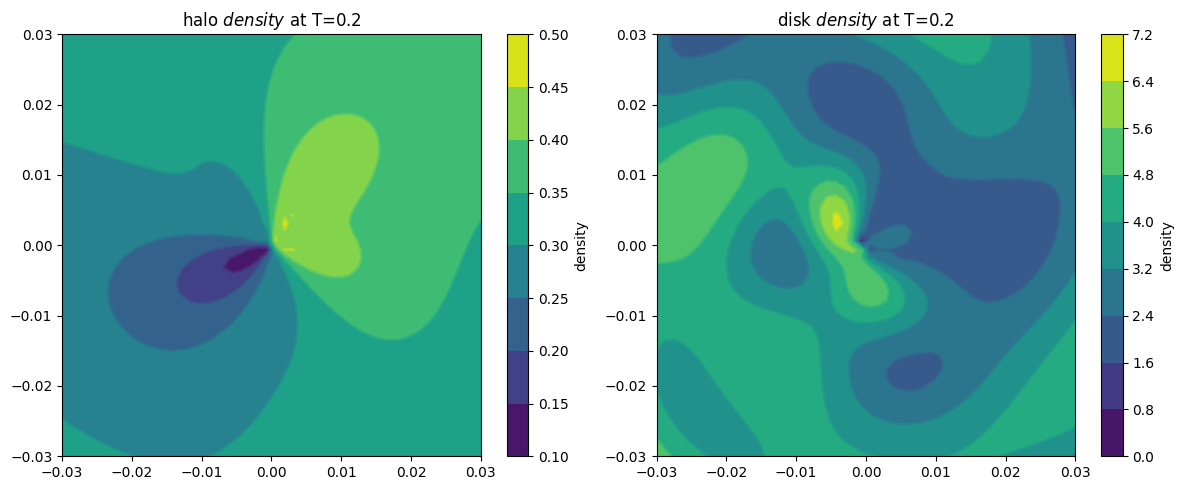

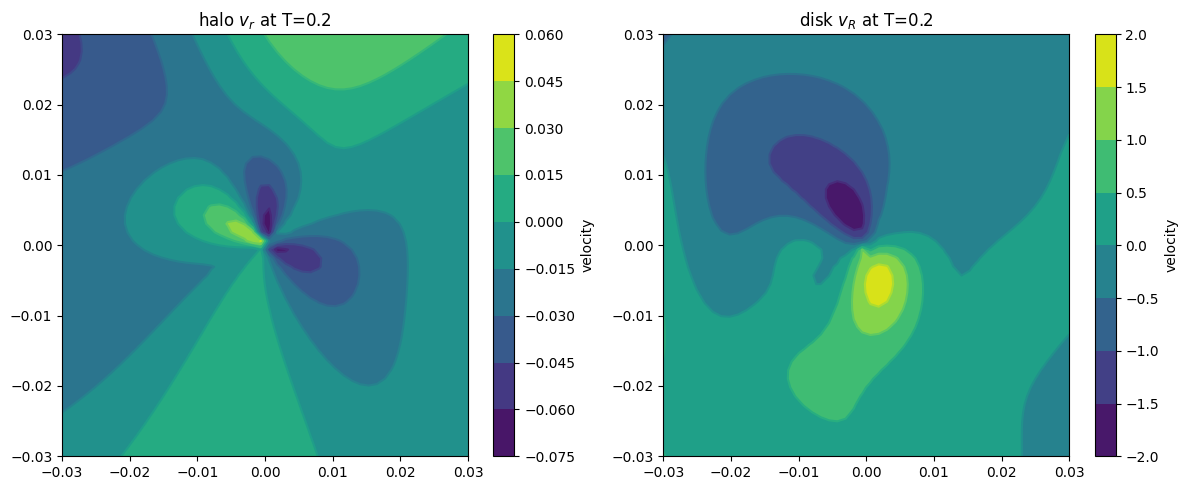

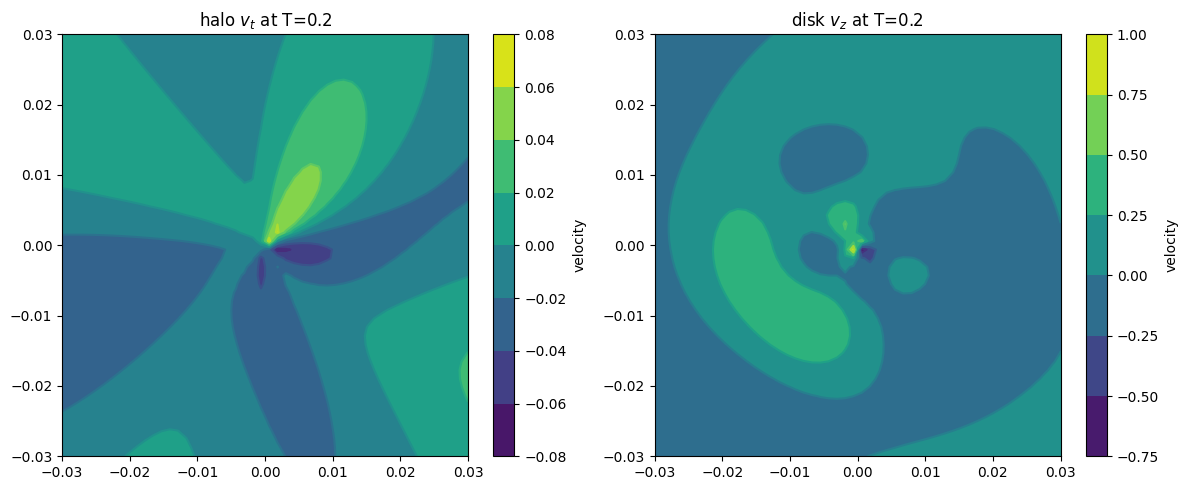

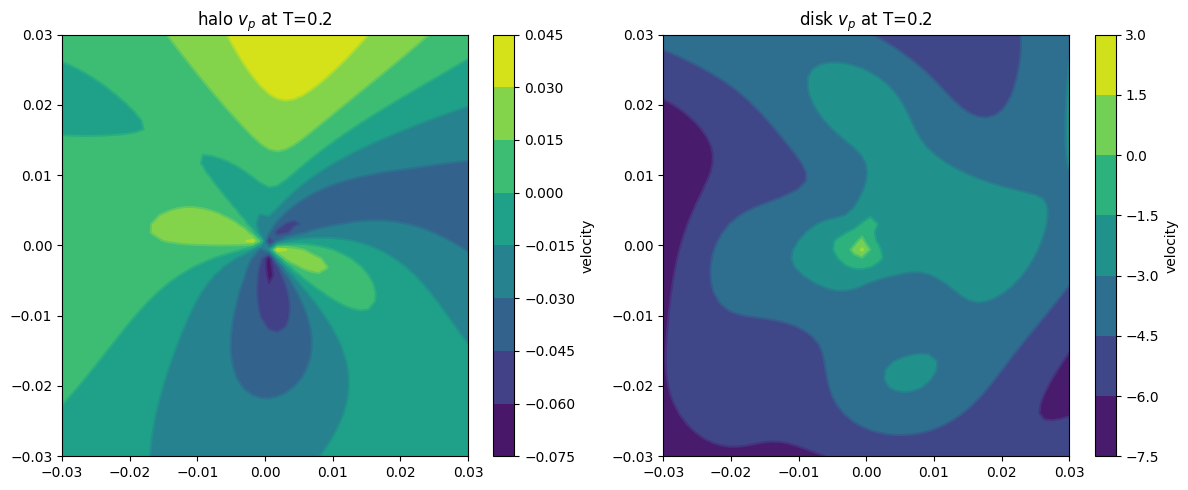

In [6]:
plt.rcParams['figure.figsize'] = [12, 5]

# Make the mesh
x = np.linspace(-rmax, rmax, npix)
y = np.linspace(-rmax, rmax, npix)
xv, yv = np.meshgrid(x, y)

import matplotlib.pyplot as plt
key = list(halo_surfaces.keys())[-1]

for i in range(1, 5):
    fig, ax = plt.subplots(1, 2)
    # Halo
    u = halo_basis.getFieldLabels()[i]
    wgt = halo_surfaces[key]['weight']
    ax[0].contour(xv, yv, halo_surfaces[key][u]/wgt)
    c1 = ax[0].contourf(xv, yv, halo_surfaces[key][u]/wgt)
    # Disk
    v = disk_basis.getFieldLabels()[i]
    wgt = disk_surfaces[key]['weight']
    ax[1].contour(xv, yv, disk_surfaces[key][v]/wgt)
    c2 = ax[1].contourf(xv, yv, disk_surfaces[key][v]/wgt)
    # Decoration
    ax[0].set_title(r'halo ${}$ at T={}'.format(u, key))
    ax[1].set_title(r'disk ${}$ at T={}'.format(v, key))
    if i==1:
        plt.colorbar(c1, ax=ax[0], label='density')
        plt.colorbar(c2, ax=ax[1], label='density')
    else:
        plt.colorbar(c1, ax=ax[0], label='velocity')
        plt.colorbar(c2, ax=ax[1], label='velocity')
    plt.tight_layout()
    plt.tight_layout()
    plt.show()

## Saving the coefficients

At this point, it makes sense to save the coefficients that you have just created.  This is sone with the following call:

In [7]:
! rm velcoefs_halo.h5 velcoefs_disk.h5
halo_coefs.WriteH5Coefs('velcoefs_halo.h5')
disk_coefs.WriteH5Coefs('velcoefs_disk.h5')

We now have a EXP HDF5 velocity coefficient file called `velcoefs.h5`.    As an example, let's try reading the newly created file into another coefficient container, `coefs2`.  The container has a member function called `CompareStanzas` which will check on the contents.  Let's do it.

In [8]:
# Now try reading it in
#
coefs2 = pyEXP.coefs.Coefs.factory('velcoefs_halo.h5')
print("Type is", type(coefs2))
print("Geometry is", coefs2.getGeometry())

# Now compare with the original
#
coefs2.CompareStanzas(halo_coefs)

Type is <class 'pyEXP.coefs.SphFldCoefs'>
Geometry is sphere
Times are the same, now checking parameters at each time
Parameters are the same, now checking coefficients


True

This member function will print differences.  No differenced should be printed, of course.